In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl


In [3]:
def unpickle(file):
    with open(file, 'rb') as f:              # assign file object to f
        data_dict = pkl.load(f, encoding='bytes')  # correct assignment and spelling
    return data_dict

In [4]:
import os
data_folder = r"D:\ML League\Intelligence-Sig-Recs-2025\NonMandatoryTasks\SemanticDatasetComparison\cifar-10-batches-py"

train_data = []
train_label = []

for i in range(1,6):
    batch_path = os.path.join(data_folder , f"data_batch_{i}")
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])
    
X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

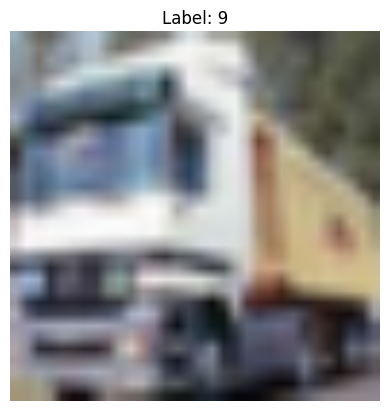

In [5]:
#Visualising Images

img = X_train[1]
img_label = y_train[1]

r = img[0:1024].reshape(32,32)
g = img[1024:2048].reshape(32,32)
b = img[2048:3072].reshape(32,32)

img_view = np.stack([r,g,b] , axis = 2)

plt.imshow(img_view, interpolation='bilinear') 
plt.title(f"Label: {img_label}")
plt.axis('off')   # turn off the axis
plt.show()


In [6]:
from PIL import Image

In [7]:
# Now resizing images as it is important for our OPEN AI CLIP Model which accepts images in 224x224

def cifar_to_pil(img_flat, target_size=224):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize((target_size, target_size), Image.BILINEAR)
    return pil_img

images = [cifar_to_pil(X_train[i]) for i in range(len(X_train))]

In [8]:
import torch
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast = 'True')

Using device: cuda


In [9]:
Classes = set(y_train)
print(Classes)

cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

Classes_named = np.array([cifar10_classes[label] for label in y_train])
Classes_named

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}


array(['frog', 'truck', 'truck', ..., 'truck', 'automobile', 'automobile'],
      shape=(50000,), dtype='<U10')

In [10]:
model.eval()

all_embeddings = []

for i in tqdm(range(0, len(images), 64)):
    batch = images[i:i+64]
    inputs = processor(images=batch, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        emb = model.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True) 
        all_embeddings.append(emb.cpu())


image_embeddings = torch.cat(all_embeddings, dim=0)
print("Embeddings shape:", image_embeddings.shape)


100%|██████████| 782/782 [05:26<00:00,  2.40it/s]


Embeddings shape: torch.Size([50000, 512])


In [11]:
class_map_named = {class_name : [] for class_name in np.unique(Classes_named)}

for i,class_name in enumerate(Classes_named):
    class_map_named[class_name].append(image_embeddings[i])

In [12]:
for class_name in class_map_named:
    class_map_named[class_name] = torch.stack(class_map_named[class_name])

In [13]:
from torch.nn.functional import normalize

classes = list(class_map_named.keys())
num_classes = len(classes)
similarity_matrix = np.zeros((num_classes,num_classes))

batch_size = 500

for i,class_A in enumerate(classes):
    A = normalize(class_map_named[class_A], dim = 1).to(device)
    for j,class_B in enumerate(classes):
        B = normalize(class_map_named[class_B], dim=1).to(device)
        all_sims = []
        
        for k in range(0, A.shape[0], batch_size):
            sims = torch.mm(A[k:k+batch_size], B.T)
            all_sims.append(sims)

        all_sims = torch.cat(all_sims, dim=0)
        avg_similarity = all_sims.mean().item()
        similarity_matrix[i, j] = avg_similarity

In [14]:
all_sims.shape


torch.Size([5000, 5000])

In [15]:
# If we save this as a dataframe we can visualize things easily
import pandas as pd

sim_df = pd.DataFrame(similarity_matrix, index = classes , columns = classes)
sim_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0.779658,0.717664,0.725984,0.709330,0.715564,0.696835,0.727171,0.693145,0.725892,0.716385
automobile,0.717664,0.812900,0.706890,0.712378,0.711672,0.706677,0.722247,0.709786,0.709346,0.758362
bird,0.725984,0.706890,0.802716,0.772018,0.782294,0.759157,0.795324,0.744992,0.702166,0.699148
cat,0.709330,0.712378,0.772019,0.838538,0.767584,0.815949,0.803668,0.754731,0.696473,0.702330
deer,0.715564,0.711672,0.782294,0.767583,0.840780,0.763338,0.790175,0.781269,0.706989,0.710550
dog,0.696835,0.706677,0.759157,0.815949,0.763338,0.829682,0.786762,0.758107,0.683078,0.693409
frog,0.727171,0.722247,0.795324,0.803668,0.790175,0.786762,0.850174,0.751229,0.713310,0.717134
horse,0.693145,0.709786,0.744992,0.754731,0.781269,0.758107,0.751229,0.824364,0.691372,0.705471
ship,0.725892,0.709346,0.702166,0.696473,0.706989,0.683078,0.713310,0.691371,0.791660,0.723809
truck,0.716385,0.758362,0.699148,0.702330,0.710550,0.693409,0.717134,0.705471,0.723809,0.804494


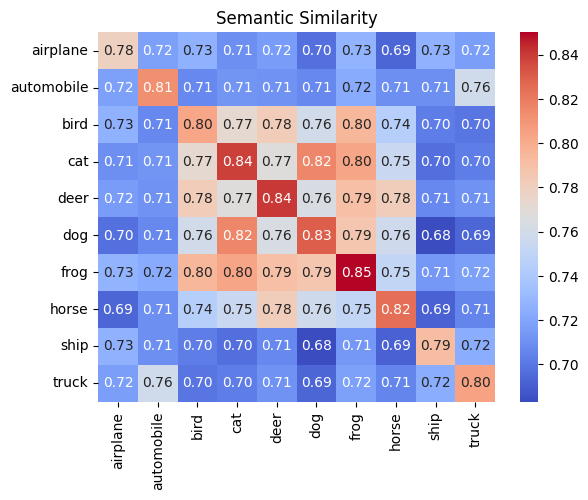

In [16]:
import seaborn as sns

sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Semantic Similarity")
plt.show()

As We can See here we have the complete similiartity matrix computed on average similiartiy of each class with the respective other class with which it is compared.So observing the final matrix we can see the digaonls which represent the similiarity within classes is comparitviely higher than the rest and Among the off diagonal similarity between DOG and CAT is actually good.